In [1]:
# Kết nối COLAB với GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Unzip file data.zip
%cd /content/gdrive/MyDrive/fraud_data
!unzip fraud_data.zip

/content/gdrive/MyDrive/fraud_data
Archive:  fraud_data.zip
  inflating: creditcard.csv          


In [7]:
# Đọc dữ liệu
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/fraud_data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# Đếm số dòng dữ liệu 
df.count()
#  284807 dòng dữ liệu

Time      284807
V1        284807
V2        284807
V3        284807
V4        284807
V5        284807
V6        284807
V7        284807
V8        284807
V9        284807
V10       284807
V11       284807
V12       284807
V13       284807
V14       284807
V15       284807
V16       284807
V17       284807
V18       284807
V19       284807
V20       284807
V21       284807
V22       284807
V23       284807
V24       284807
V25       284807
V26       284807
V27       284807
V28       284807
Amount    284807
Class     284807
dtype: int64

In [10]:
# Số dòng dữ liệu mỗi class
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

- Việc sử dụng classification thông thường để train model không hiệu quả.
- Vì Fraud và Normal chênh lệch khá cao. 

**Train model Auto Encoder**

- Train dữ liệu Normal bằng Encoder
- f(x) ~= x: có nghĩa là khi đưa dữ liệu gì vào trả ra dữ liệu đó (Input ~= Output)

In [11]:
# Drop cột time
df_no_time = df.drop(columns=['Time'])
df_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
# Chuẩn hóa dữ liệu cột Amount
from sklearn.preprocessing import StandardScaler

df_no_time ['Amount'] = StandardScaler().fit_transform(df_no_time['Amount'].values.reshape(-1,1))

In [13]:
df_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [25]:
# Phân chia dữ liệu train test
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df_no_time, test_size=0.2, random_state=42)

# Điều chế dữ liệu train
x_train = x_train[x_train['Class']==0]
x_train = x_train.drop(columns=['Class'])

# Điều chế x_test
y_test = x_test['Class']
x_test = x_test.drop(columns=['Class']) 

x_train = x_train.values
x_test = x_test.values

In [27]:
# Kiểm tra dữ liệu train test
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(227451, 29)
(56962, 29)
(56962,)


In [28]:
# Build Model 
from keras.layers import Input, Dense
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint

# Xây dựng model
input_dimension = x_train.shape[1]
hidden_size = 128

input_layer = Input(shape=(input_dimension,))

# Encoder
encoder = Dense(hidden_size, activation = "relu") (input_layer)
encoder = Dense(hidden_size //2, activation="relu") (encoder)
encoder = Dense(hidden_size //4, activation="relu") (encoder)

# Decoder
decoder = Dense(hidden_size //4, activation="relu") (encoder)
decoder = Dense(hidden_size //2, activation="relu") (decoder)
decoder = Dense(hidden_size, activation = "relu") (decoder)

# Output
output_layer = Dense(input_dimension, activation="relu") (decoder)

auto_encoder_model= Model(inputs = input_layer, outputs = output_layer)
auto_encoder_model.compile (optimizer ="adam", loss="mse", metrics=['accuracy'])
auto_encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_7 (Dense)             (None, 128)               3840      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dense_12 (Dense)            (None, 128)               8320

- Input: 29
- Output: 29

In [36]:
# Train model
n_epochs = 50
n_batch_size = 32

save_best = ModelCheckpoint(filepath = "/content/gdrive/MyDrive/fraud_data/best.h5", 
                            monitor='val_loss', verbose=1, save_best_only=True)

history = auto_encoder_model.fit(x_train, x_train, batch_size=n_batch_size, epochs=n_epochs,verbose=1,
                                 shuffle=True, callbacks=[save_best],
                                 validation_data=(x_test, x_test))

Epoch 1/50
7104/7108 [============================>.] - ETA: 0s - loss: 0.8614 - accuracy: 0.3535
Epoch 1: val_loss improved from inf to 0.88584, saving model to /content/gdrive/MyDrive/fraud_data/best.h5
7108/7108 [==============================] - 34s 5ms/step - loss: 0.8613 - accuracy: 0.3535 - val_loss: 0.8858 - val_accuracy: 0.3571
Epoch 2/50
7108/7108 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.3533
Epoch 2: val_loss did not improve from 0.88584
7108/7108 [==============================] - 46s 6ms/step - loss: 0.8613 - accuracy: 0.3533 - val_loss: 0.8860 - val_accuracy: 0.3558
Epoch 3/50
7107/7108 [============================>.] - ETA: 0s - loss: 0.8614 - accuracy: 0.3535
Epoch 3: val_loss did not improve from 0.88584
7108/7108 [==============================] - 36s 5ms/step - loss: 0.8613 - accuracy: 0.3535 - val_loss: 0.8860 - val_accuracy: 0.3558
Epoch 4/50
7101/7108 [============================>.] - ETA: 0s - loss: 0.8606 - accuracy: 0.3532
Epoch

No handles with labels found to put in legend.


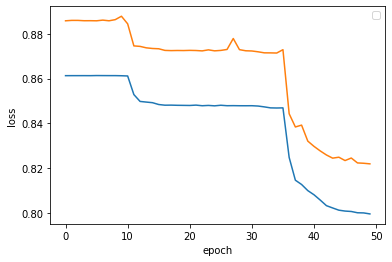

In [38]:
# In history

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend()

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [39]:
# Kiểm tra việc tái tạo trong tập test
import numpy as np

# Dự đoán
predicts = auto_encoder_model.predict(x_test)
mse = np.mean(np.power(x_test - predicts,2), axis=1)
err_df = pd.DataFrame({'error': mse, 'truth': y_test})

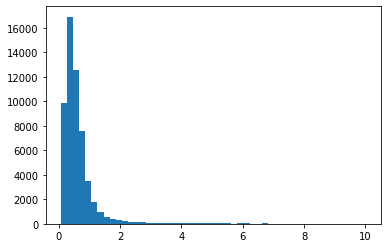

In [33]:
# In ra histogram của error khi tái tạo các điểm Normal trong tập test
normal_error_df = err_df[(err_df['truth']==0) & (err_df['error'] < 10)]

_ = plt.hist(normal_error_df.error.values, bins= 50)

- Các lỗi error khi tái tạo các điểm Normal phân phối nhiều nhất từ 0 - 2.3
- Các điểm Normal dùng để train model, tái tạo sẽ có error rất thấp 

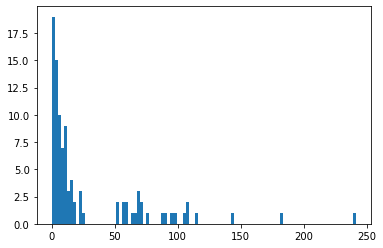

In [40]:
# In ra histogram của error khi tái tạo các điểm Fraud (các điểm dữ liệu không được train) trong tập test
fraud_error_df = err_df[(err_df['truth']==1)]
_ = plt.hist(fraud_error_df.error.values, bins= 100)

<function matplotlib.pyplot.show>

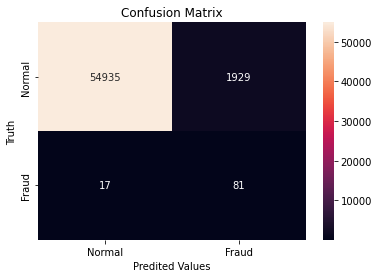

In [41]:
# Vẽ ra confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ngưỡng để phân biệt Fraud (2.3 của Normal)
threshold = 2.3

# y dự đoán
y_pred = [1 if e > threshold else 0 for e in err_df.error.values]
conf_matrix = confusion_matrix(err_df.truth, y_pred)

# Vẽ
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=['Normal','Fraud'], annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predited Values")
plt.ylabel("Truth")
plt.show

- Có 54935 điểm dữ liệu Normal được nhận là Normal.
- Có 1929 điểm dữ liệu Normal được nhận là Fraud (càng giảm càng tốt).
- Có tổng 98 giao dịch Fraud: 
  
  - 17 điểm dữ liệu nhận nhầm thành Normal.
  - 81 điểm dữ liệu nhận đúng Fraud.

  20% sai, 80% đúng

  Nhiệm vụ: giảm tối thiểu nhận nhầm Fraud thành Normal và ngược lại.